In [2]:
import numpy as np
import scipy.ndimage.filters as fi
from numpy.linalg import norm
import scipy.io as sio
from tqdm import tqdm
import math
import cv2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import multivariate_normal

In [3]:
def generate_gaussian_kernel(size, mu, sigma):
    x, y = np.mgrid[-1.0:1.0:(size[1] * 1j), -1.0:1.0:(size[0] * 1j)]
    xy = np.column_stack([x.flat, y.flat])
    mu = np.array([mu, mu])
    sigma = np.array([sigma, sigma])
    covariance = np.diag(sigma**2)
    z = multivariate_normal.pdf(xy, mean=mu, cov=covariance)
    z = z.reshape(x.shape)
    return z/z.sum()

In [4]:
def apply_filt(A, block_dimension, fun):
    # padding matrix
    B = np.copy(A)
    X_block = block_dimension[0]
    Y_block = block_dimension[1]

    marginX = math.floor(X_block/2)
    marginY = math.floor(Y_block/2)
    
    block_matrix = np.zeros((X_block, Y_block)).reshape(X_block, Y_block)
    block = (marginX, marginY)
    
    
    B = np.pad(B, (block, block), 'constant', constant_values=(0))
    X,Y = B.shape[:2]
    C = np.zeros((X, Y), dtype=np.uint8).reshape(X, Y)
    
    
    #apply fun
    for i in tqdm(range(marginX, X - marginX)):
        for j in range(marginY, Y - marginY):
            for x in range(-marginX, marginX + 1):
                for y in range(-marginY, marginY + 1):
                    block_matrix[x + marginX, y + marginY] = B[i + x, j + y]
            weights_p = fun(block_matrix)
            C[i, j] = np.multiply(block_matrix, weights_p).sum()
           
    return C
    

In [9]:
def non_local_means(block):
    
    sigma = 1
    omega_matrix = np.copy(block)
    low_sigma = 1
    alfa=10
    context = np.zeros((5, 5))
    center_point_context = np.zeros((5, 5))
    X, Y = block.shape[:2]
    omegas_array = np.zeros(X * Y)
    block = np.pad(block, ((2, 2), (2, 2)), 'constant', constant_values=(0))
    
    centerX = math.ceil(X / 2)
    centerY = math.ceil(Y / 2)
    
    for x in range(-2, 3):
                for y in range(-2, 3):
                        center_point_context[x + 2, y + 2] = block[centerX + x, centerY + y]
                    
    
    gaussian_filter = generate_gaussian_kernel((5,5), 0, sigma)
    center_point_context = np.multiply(center_point_context, gaussian_filter)
    
    for i in range(1, X + 1):
        for j in range(1, Y + 1):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    context[x + 2, y + 2] = block[i + x, j + y]
                    
            
            n_p = np.multiply(context, gaussian_filter)
            
            omega = norm(n_p - center_point_context)
            omega_matrix[i-1, j-1] = omega
            
    omega_matrix =  np.exp((-np.power(omega_matrix, 2) / (alfa * (low_sigma**2))))
    return omega_matrix/omega_matrix.sum()
    
    

In [13]:
mat_file = A_input = sio.loadmat("MR_data.mat")
img = mat_file['I_noisy1']
img = img.astype(np.uint8)
padded_img = apply_filt(img, [11, 11], non_local_means)


100%|██████████| 256/256 [02:09<00:00,  1.92it/s]


In [14]:
img.dtype

dtype('uint8')

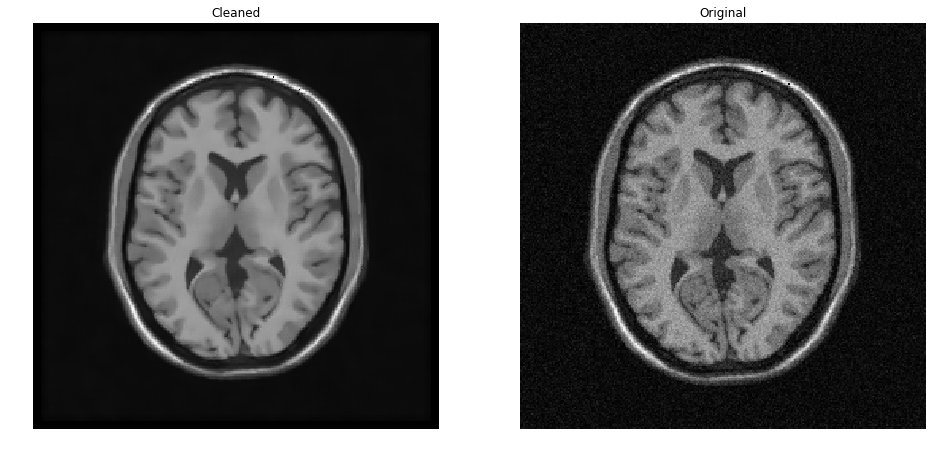

In [15]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(padded_img, cmap="gray")
plt.title("Cleaned")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")
plt.show()